In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.utils as vutils
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader, random_split

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor


from mmd import _mix_rq_kernel, _mix_rbf_kernel, _distance_kernel, mmd2, gradient_penalty
from architecture import Generator_MNIST, Discriminator_MNIST
from utils import show, weights_init
print(device)

cuda


In [2]:
batch_size=128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(os.getcwd(), train=True, transform=transform, download=False)

samples_per_class = {i: [] for i in range(10)}  

for data, target in train_set:
    if len(samples_per_class[target]) < 600:
        samples_per_class[target].append(data.view(-1))
    if all(len(samples) == 600 for samples in samples_per_class.values()):
        break

# Combine all the collected samples into a single tensor
y = torch.cat([torch.stack(samples_per_class[i]) for i in range(10)]).to(device)
print(y.shape)


batch_size = 500
dataset = TensorDataset(y.reshape(-1, 1, 28, 28))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

torch.Size([6000, 784])


In [3]:
split_sizes = [len(dataset) // 2, len(dataset) - (len(dataset) // 2)]

# Randomly split the dataset into two parts
train_dataset, test_dataset = random_split(dataset, split_sizes)

# Create data loaders for each split
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Without discriminator

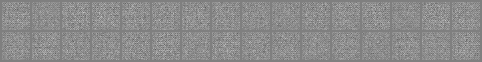

In [36]:
# Create the generator and discriminator

nz = 100 # Input noise dimension
G = Generator_MNIST(nz=nz).to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
G.apply(weights_init);

show(G);

In [37]:
lr = 0.001   # learning rate for generator
kernel = _distance_kernel
n_epochs = 500
b=batch_size

torch.manual_seed(1)  # initialize random seed for reproducibility

optimG = optim.Adam(G.parameters(), lr=lr)

Glosses = []

iter_display = 20
loss_display = 10

[0/500] 	Loss_G: 6.8019


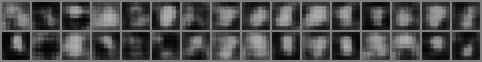

[10/500] 	Loss_G: 0.1288
[20/500] 	Loss_G: 0.0672


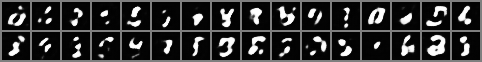

[30/500] 	Loss_G: 0.0757
[40/500] 	Loss_G: 0.0269


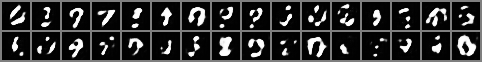

[50/500] 	Loss_G: 0.0216
[60/500] 	Loss_G: 0.0403


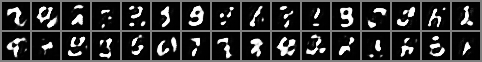

[70/500] 	Loss_G: 0.0783
[80/500] 	Loss_G: 0.0230


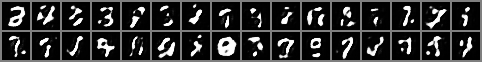

[90/500] 	Loss_G: 0.0118
[100/500] 	Loss_G: 0.0093


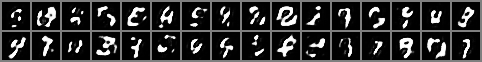

[110/500] 	Loss_G: 0.0299
[120/500] 	Loss_G: 0.0454


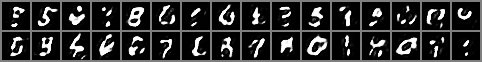

[130/500] 	Loss_G: 0.0135
[140/500] 	Loss_G: 0.0137


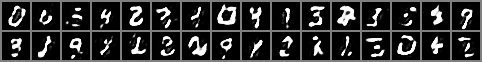

[150/500] 	Loss_G: 0.0205
[160/500] 	Loss_G: 0.0083


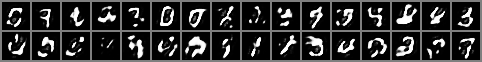

[170/500] 	Loss_G: 0.0203
[180/500] 	Loss_G: 0.0253


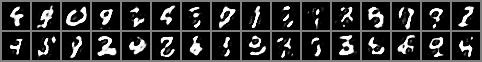

[190/500] 	Loss_G: 0.0341
[200/500] 	Loss_G: 0.0206


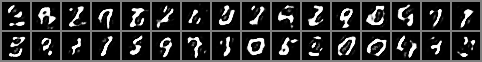

[210/500] 	Loss_G: -0.0020
[220/500] 	Loss_G: 0.0336


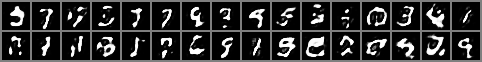

[230/500] 	Loss_G: 0.0035
[240/500] 	Loss_G: 0.0181


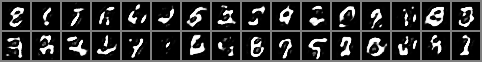

[250/500] 	Loss_G: 0.0183
[260/500] 	Loss_G: 0.0080


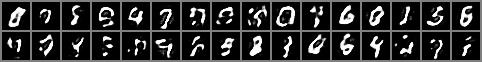

[270/500] 	Loss_G: -0.0012
[280/500] 	Loss_G: 0.0002


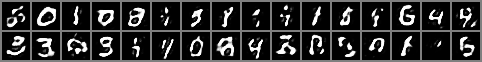

[290/500] 	Loss_G: -0.0047
[300/500] 	Loss_G: 0.0248


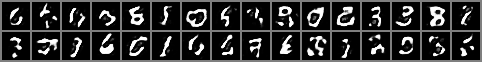

[310/500] 	Loss_G: 0.0021
[320/500] 	Loss_G: -0.0014


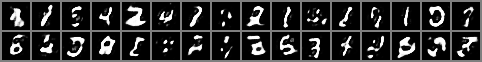

[330/500] 	Loss_G: 0.0100
[340/500] 	Loss_G: 0.0215


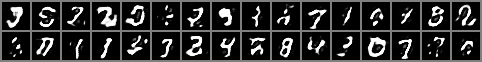

[350/500] 	Loss_G: 0.0088
[360/500] 	Loss_G: 0.0044


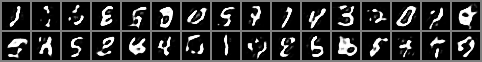

[370/500] 	Loss_G: -0.0022
[380/500] 	Loss_G: 0.0186


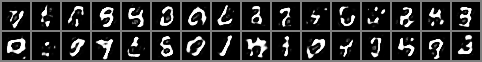

[390/500] 	Loss_G: 0.0190
[400/500] 	Loss_G: 0.0118


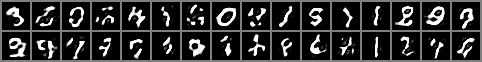

[410/500] 	Loss_G: 0.0136
[420/500] 	Loss_G: 0.0033


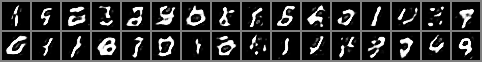

[430/500] 	Loss_G: 0.0069
[440/500] 	Loss_G: 0.0084


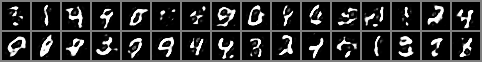

[450/500] 	Loss_G: 0.0182
[460/500] 	Loss_G: 0.0063


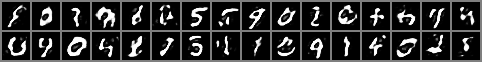

[470/500] 	Loss_G: -0.0054
[480/500] 	Loss_G: 0.0049


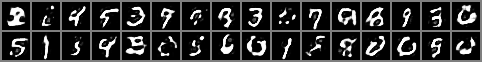

[490/500] 	Loss_G: 0.0290


In [38]:
# Main loop
for epoch in range(n_epochs):

    for y in data_loader:
        Gloss = torch.tensor(0.0, device=device)
        z = torch.randn(b,nz,1,1).to(device)
        x = G(z).reshape(b, 28*28)
        optimG.zero_grad()
        Gloss = mmd2(kernel, x, y[0].reshape(b, 28*28))
        Gloss.backward()
        optimG.step()

    # Output training stats
    if (epoch % loss_display == 0):
        print('[%d/%d] \tLoss_G: %.4f'
          % (epoch, n_epochs, Gloss.item()))
        Glosses.append(Gloss.item())


    if(epoch % iter_display == 0):
        show(G)

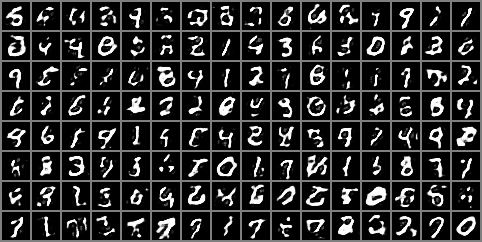

In [39]:
show(G, batch_size=128)

## With Discriminator

/users/eleves-a/2021/ahmad.rammal/miniconda3/envs/gm/lib/python3.9/site-packages/torch/nn/modules/conv.py:952: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv_transpose2d(


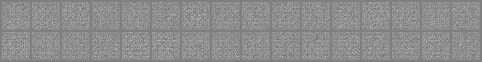

In [4]:
# Create the generator and discriminator

nz = 100 # Input noise dimension
G = Generator_MNIST(nz=nz).to(device)
G.apply(weights_init);
D = Discriminator_MNIST().to(device)
D.apply(weights_init)

show(G)

In [5]:
lr = 0.005
kernel = _distance_kernel

## parameters for training
n_epochs = 200
niterD= 5
niterG= 2
b = batch_size
gpw = 1

torch.manual_seed(1) 

optimD = optim.Adam(D.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=5e-1)
optimG = optim.Adam(G.parameters(), lr=1e-4, betas=(0.9, 0.999))

# optimG = optim.Adam(G.parameters(), lr=0.01)
# optimD = optim.Adam(D.parameters(), lr=lr)

Glosses = []
Dlosses = []

iter_display = 2000
loss_display = 10

[0/200] 	Loss_D: 10918.5023	Loss_G: 10881.5838


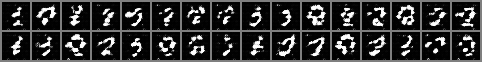

[10/200] 	Loss_D: 11153.8464	Loss_G: 1101.8651


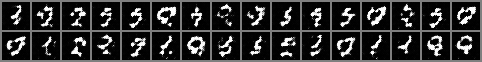

[20/200] 	Loss_D: 12271.0495	Loss_G: 12322.8211


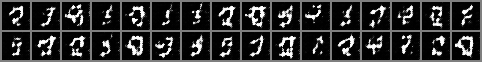

[30/200] 	Loss_D: 12865.3542	Loss_G: 12899.3600


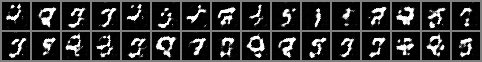

[40/200] 	Loss_D: 14063.4360	Loss_G: 14106.3302


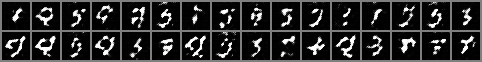

[50/200] 	Loss_D: 13733.3506	Loss_G: 14070.8514


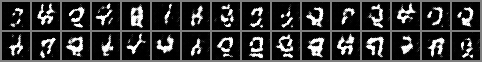

[60/200] 	Loss_D: 15146.8429	Loss_G: 15283.7811


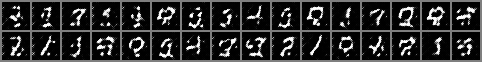

[70/200] 	Loss_D: 16175.4604	Loss_G: 16226.1343


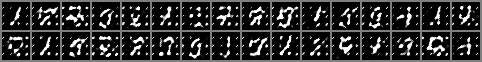

[80/200] 	Loss_D: 15648.6134	Loss_G: 16448.4639


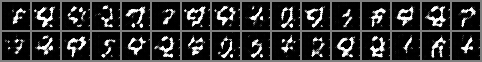

[90/200] 	Loss_D: 18259.5879	Loss_G: 18343.6738


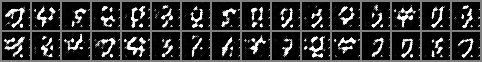

[100/200] 	Loss_D: 19280.9482	Loss_G: 19332.4554


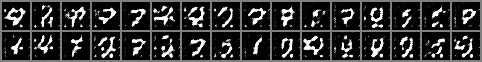

[110/200] 	Loss_D: 20055.8363	Loss_G: 20121.4723


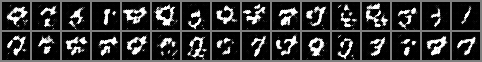

[120/200] 	Loss_D: 20551.7887	Loss_G: 7488.9686


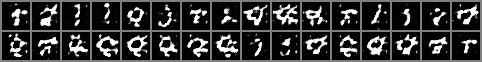

[130/200] 	Loss_D: 22278.7731	Loss_G: 22340.6491


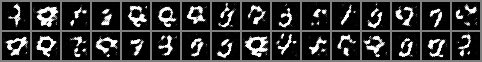

[140/200] 	Loss_D: 23273.0726	Loss_G: 23334.1149


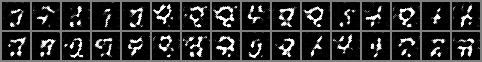

[150/200] 	Loss_D: 24449.3014	Loss_G: 24546.6159


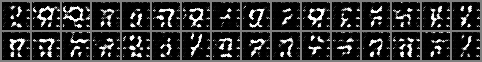

[160/200] 	Loss_D: 25684.7210	Loss_G: 25765.5547


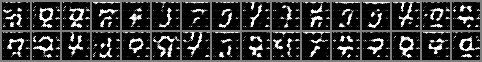

[170/200] 	Loss_D: 26353.2799	Loss_G: 14826.0120


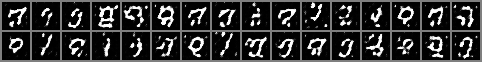

[180/200] 	Loss_D: 27715.2783	Loss_G: 27775.4476


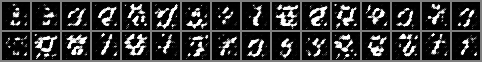

[190/200] 	Loss_D: 27661.2754	Loss_G: 26778.4564


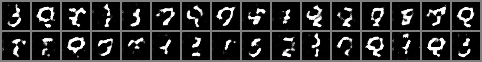

In [12]:
# Main loop
torch.manual_seed(1) 

for epoch in range(n_epochs):
    
        ############################
        ### Train discriminator (niterD iterations)
        ############################
            
        Gloss = torch.tensor(0.0, device=device)
        Dloss = torch.tensor(0.0, device=device)
        for iter in range(0, niterD):
            Dloss_cum = 0.0
            for y in train_loader:
                optimD.zero_grad()
                z = torch.randn(b, nz, 1, 1).to(device)
                x = G(z)
                Dloss = -mmd2(kernel, D(x), D(y[0])) + gpw*gradient_penalty(D, kernel, x, y[0])
                Dloss.backward()
                optimD.step()
                Dloss_cum += -Dloss.item()
            Dloss_cum /= len(train_loader)
        
        
        ############################
        ### Train generator (niterG iterations)
        ############################
        for iter in range(0, niterG):
            Gloss_cum = 0.0
            for y in test_loader:
                optimG.zero_grad()
                z = torch.randn(b,nz,1,1).to(device)
                x = G(z)
                Gloss = mmd2(kernel, D(x), D(y[0]))
                Gloss.backward()
                optimG.step()
                Gloss_cum += Gloss.item()
            Gloss_cum /= len(test_loader)
        # print(Gloss_cum)
        # Output training stats
        if (epoch%loss_display ==0):
            print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
            % (epoch, n_epochs, Dloss_cum, Gloss_cum))
            Glosses.append(Gloss_cum)
            Dlosses.append(Dloss_cum)
            show(G);

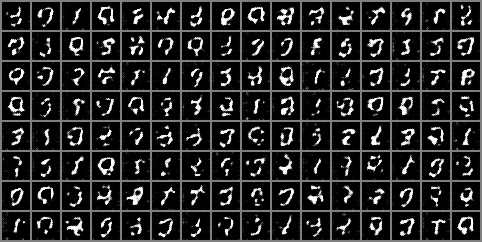

In [13]:
show(G, batch_size=128)

In [14]:
torch.save(G.state_dict(), 'generator_MNIST_with_D.pth')